In [1]:
import pandas as pd
import numpy as np
import rebound
import matplotlib.pyplot as plt
from matplotlib import colors
from rebound.interruptible_pool import InterruptiblePool
import scipy.optimize as opt
import cmath

In [2]:
from celmech.disturbing_function import df_coefficient_Ctilde
from celmech.disturbing_function import evaluate_df_coefficient_dict
from celmech.disturbing_function import laplace_b as b

In [3]:
def b1(alpha):
    return b(1.5, 1, 0, alpha)
def b2(alpha):
    return b(1.5, 2, 0, alpha)

$$ T\cdot\vec{e} = \vec{A} $$

In [4]:
def getT(mass, alpha):
    m1, m3 = mass
    mu1, mu3 = m1/(m1+m3),m3/(m1+m3)
    
    alpha12, alpha23 = alpha
    alpha13 = alpha12*alpha23
    
    ec12 = alpha12**(-1/4)*alpha23**(3/4)*alpha23**(-1/8)*(1-alpha12)
    ec23 = alpha23**(-1/2)*alpha12**(1/8)*(1-alpha23)
    ec13 = alpha13**(-1/2)*(1-alpha13)
    
    d = (ec12 - ec23)/ec13
    mu = (mu3-mu1)/(mu1+mu3)
    gamma = 1/(3+6*d**2+8*mu*d-d**4)
    T = np.array([[gamma*mu1*(1-d)**3*(3+d), -gamma*(mu3*(1+d)**3*(3-d)+mu1*(1-d)**3*(3+d)), gamma*mu3*(1+d)**3*(3-d)],
                 [-np.sqrt(mu1*mu3), 0, np.sqrt(mu1*mu3)],
                 [mu1, 0, mu3]])
    return T

In [5]:
def AtoE(alpha, mass, amp, phi):
    m1, m3 = mass
    A1, A2, A3 = amp
    p1, p2, p3 = phi
    
    invT = np.linalg.inv(getT(mass, alpha))
    A_vec = np.array([[A1*cmath.exp(1j*p1)], [A2*cmath.exp(1j*p2)], [A3*cmath.exp(1j*p3)]])
    e_vec = invT @ A_vec
    
    e1, e2, e3 = np.abs(e_vec[0][0]), np.abs(e_vec[1][0]), np.abs(e_vec[2][0])
    pom1, pom2, pom3 = cmath.phase(e_vec[0][0]), cmath.phase(e_vec[1][0]), cmath.phase(e_vec[2][0])
    
    return (e1, e2, e3), (pom1, pom2, pom3)

In [6]:
def EtoA(alpha, mass, ecc, pomega):
    e1, e2, e3 = ecc
    pom1, pom2, pom3 = pomega
    
    T = getT(mass, alpha)
    e_vec = np.array([[e1*cmath.exp(1j*pom1)], [e2*cmath.exp(1j*pom2)], [e3*cmath.exp(1j*pom3)]])
    A_vec = T @ e_vec
    
    amp1, amp2, amp3 = np.abs(A_vec[0][0]), np.abs(A_vec[1][0]), np.abs(A_vec[2][0])
    phi1, phi2, phi3 = cmath.phase(A_vec[0][0]), cmath.phase(A_vec[1][0]), cmath.phase(A_vec[2][0])
    
    return amp1, amp2, amp3, phi1, phi2, phi3

In [7]:
def breathingON(mass, A1_p):
    m1, m3 = mass
    
    x1, y1 = np.sqrt(m3/m1), np.sqrt(m1/m3)
    x2, y2 = 1, 1
    
    if m1==m3:
        A1_b = A1_p / np.sqrt(2)
        A2_b = A1_b*x2/x1
        theta = np.pi/2
    else:
        def A2(theta):
            return 2*A1_p*x2*y2*np.cos(theta) / np.sqrt((x1*y2-x2*y1)**2 + 4*x1*x2*y1*y2*(np.cos(theta))**2)
        def A1(theta):
            return A1_p*(x1*y2-x2*y1) / np.sqrt((x1*y2-x2*y1)**2 + 4*x1*x2*y1*y2*(np.cos(theta))**2)
        def e21_min(theta):
            return -(x1*A2(theta) + x2*A1(theta))**2
        def e32_min(theta):
            return -(y1*A2(theta) + y2*A1(theta))**2
        
        minimizer_kwargs = dict(method="L-BFGS-B", bounds=[(0,2*np.pi)])
        result21 = opt.basinhopping(e21_min, x0=0, minimizer_kwargs=minimizer_kwargs, niter=50)
        result32 = opt.basinhopping(e32_min, x0=0, minimizer_kwargs=minimizer_kwargs, niter=50)
        
        if np.fabs(result21.fun) > np.fabs(result32.fun):
            theta = result21.x
            A1_b, A2_b = A1(theta), A2(theta)
        else:
            theta = result32.x
            A1_b, A2_b = A1(theta), A2(theta)
    
    return A1_b, A2_b, theta

In [8]:
MASS = 3e-6, 3e-6
POMEGA = 0, 2*np.pi/3, -2*np.pi/3
f = 0.1
timescale = 1.5e6

In [9]:
def simNoBreathing(alpha):
    alpha12, alpha23 = alpha
    P1, P2, P3 = alpha12**(3/2), 1, 1/alpha23**(3/2)
    mu1, mu3 = MASS
    ECC = f*(1-alpha12), f*(1-(alpha12+alpha23)/2), f*(1-alpha23)
    
    amp1, amp2, amp3, phase1, phase2, phase3  = EtoA(alpha, MASS, ECC, POMEGA)
    ecc_nb, pomega_nb = AtoE(alpha, MASS, (amp1, 0, amp3), (phase1, phase2, phase3))
    ecc1, ecc2, ecc3 = ecc_nb
    pomega1, pomega2, pomega3 = pomega_nb
    
    # start simulation
    sim = rebound.Simulation()
    sim.units = ('yr', 'AU', 'Msun')

    # add star, planet 1, planet 2
    sim.add(m=1.)
    sim.add(m=mu1, P=P1, e=ecc1, pomega=pomega1)
    sim.add(P=P2, e=ecc2, pomega=pomega2)
    sim.add(m=mu3, P=P3, e=ecc3, pomega=pomega3)
    ps = sim.particles
    ps[1].r = ps[1].a*(ps[1].m/3/ps[0].m)**(1/3)
    ps[2].r = ps[2].a*(ps[2].m/3/ps[0].m)**(1/3)

    sim.move_to_com()
    sim.integrator = "whfast"
    sim.dt = sim.particles[1].P/20
    sim.collision = "direct"
    
    sim.init_megno()
    try:
        sim.integrate(timescale, exact_finish_time=0)
        megno = sim.calculate_megno() 
        return megno
    except rebound.Collision:
        return 4000

#     time = np.logspace(0,7,num=100)
#     for T in time:
#         try:
#             sim.integrate(T, exact_finish_time=0)
#         except rebound.Collision:
#             return sim.t
#     return 1e8

In [10]:
def simWithBreathing(alpha):
    alpha12, alpha23 = alpha
    P1, P2, P3 = alpha12**(3/2), 1, 1/alpha23**(3/2)
    mu1, mu3 = MASS
    ECC = f*(1-alpha12), f*(1-(alpha12+alpha23)/2), f*(1-alpha23)
    
    amp1, amp2, amp3, phase1, phase2, phase3 = EtoA(alpha, MASS, ECC, POMEGA)   
    amp1_wb, amp2_wb, theta = breathingON(MASS, amp1)
    ecc_wb, pomega_wb = AtoE(alpha, MASS, (amp1_wb, amp2_wb, amp3), (phase1, phase2+theta, phase3))
    
    ecc1, ecc2, ecc3 = ecc_wb
    pomega1, pomega2, pomega3 = pomega_wb
    
    # start simulation
    sim = rebound.Simulation()
    sim.units = ('yr', 'AU', 'Msun')

    # add star, planet 1, planet 2
    sim.add(m=1.)
    sim.add(m=mu1, P=P1, e=ecc1, pomega=pomega1)
    sim.add(P=P2, e=ecc2, pomega=pomega2)
    sim.add(m=mu3, P=P3, e=ecc3, pomega=pomega3)
    ps = sim.particles
    ps[1].r = ps[1].a*(ps[1].m/3/ps[0].m)**(1/3)
    ps[2].r = ps[2].a*(ps[2].m/3/ps[0].m)**(1/3)

    sim.move_to_com()
    sim.integrator = "whfast"
    sim.dt = sim.particles[1].P/20
    sim.collision = "direct"
    
    sim.init_megno()
    try:
        sim.integrate(timescale, exact_finish_time=0)
        megno = sim.calculate_megno() 
        return megno
    except rebound.Collision:
        return 4000

#     time = np.logspace(0,7,num=100)
#     for T in time:
#         try:
#             sim.integrate(T, exact_finish_time=0)
#         except rebound.Collision:
#             return sim.t
#     return 1e8

In [11]:
Ngrid_x = 100
Ngrid_y = 100

alpha12 = np.linspace(0.75,0.9,Ngrid_x)
alpha23 = np.linspace(0.75,0.9,Ngrid_y)
parameters = [[x,y] for x in alpha12 for y in alpha23]

# Ngrid = 10000
# alpha12 = np.linspace(0.75,0.9,Ngrid)
# parameters = [[x,x] for x in alpha12]

In [ ]:
pool = InterruptiblePool()
results_no_breathing = pool.map(simNoBreathing,parameters)
np.savetxt("MEGNO_nb_10%_ME.csv", results_no_breathing, delimiter=",")

results_with_breathing = pool.map(simWithBreathing,parameters)
np.savetxt("MEGNO_wb_10%_ME.csv", results_with_breathing, delimiter=",")

In [15]:
def rescale(results):
    return results
#     time_rescaled = np.zeros(len(results))
#     for i, value in enumerate(results):
#         time_rescaled[i] = round(np.log10(value)[0])
#     return time_rescaled

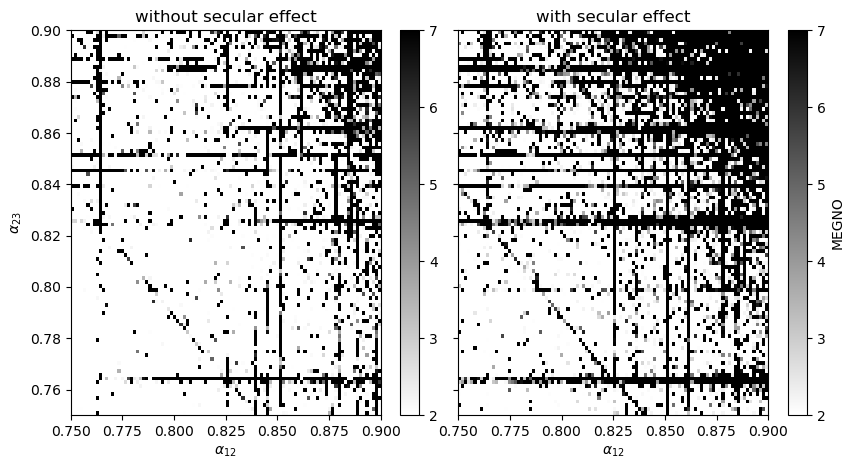

In [19]:
dataframe1 = pd.read_csv('MEGNO_nb_10%_ME.csv', header=None)
data_nb = rescale(dataframe1.values).reshape(Ngrid_y,Ngrid_x)
dataframe2 = pd.read_csv('MEGNO_wb_10%_ME.csv', header=None)
data_wb = rescale(dataframe2.values).reshape(Ngrid_y,Ngrid_x)

f, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(10,5))
f.subplots_adjust(wspace=0)

extent = [min(alpha12),max(alpha12),min(alpha23),max(alpha23)]
ax1.set_xlim(extent[0],extent[1])
ax1.set_ylim(extent[2],extent[3])
ax1.set_ylabel(r"$\alpha_{23}$")
ax1.set_xlabel(r"$\alpha_{12}$")
ax1.set_title("without secular effect")

ax2.set_xlim(extent[0],extent[1])
ax2.set_ylim(extent[2],extent[3])
ax2.set_xlabel(r"$\alpha_{12}$")
ax2.set_title("with secular effect")

im1 = ax1.imshow(data_nb.transpose(), vmin=2, vmax=7, interpolation="none", cmap="binary", origin="lower", aspect='auto', extent=extent)
cb1 = plt.colorbar(im1, ax=ax1)
im2 = ax2.imshow(data_wb.transpose(), vmin=2, vmax=7, interpolation="none", cmap="binary", origin="lower", aspect='auto', extent=extent)
cb2 = plt.colorbar(im2, ax=ax2)
cb2.set_label("MEGNO")

# im1 = ax1.imshow(data_nb.transpose(),vmin=2, vmax=8, cmap=colors.ListedColormap(['r','y','g','b','m','w']), origin="lower", aspect='auto', extent=extent)
# cb1 = plt.colorbar(im1, ax=ax1)
# im2 = ax2.imshow(data_wb.transpose(),vmin=2, vmax=8, cmap=colors.ListedColormap(['r','y','g','b','m','w']), origin="lower", aspect='auto', extent=extent)
# cb2 = plt.colorbar(im2, ax=ax2)
# cb2.set_label("Collision Time")